#  House Prices - Advanced Regression Techniques (Kaggle)
**Getting Started Prediction Competition**
https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('/content/drive/MyDrive/train_house.csv')

#eksik veri
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_percentage = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing': missing, 'Missing Percentage': missing_percentage})
print(missing_df)


              Missing  Missing Percentage
PoolQC           1453           99.520548
MiscFeature      1406           96.301370
Alley            1369           93.767123
Fence            1179           80.753425
MasVnrType        872           59.726027
FireplaceQu       690           47.260274
LotFrontage       259           17.739726
GarageType         81            5.547945
GarageYrBlt        81            5.547945
GarageFinish       81            5.547945
GarageQual         81            5.547945
GarageCond         81            5.547945
BsmtExposure       38            2.602740
BsmtFinType2       38            2.602740
BsmtQual           37            2.534247
BsmtCond           37            2.534247
BsmtFinType1       37            2.534247
MasVnrArea          8            0.547945
Electrical          1            0.068493


In [ ]:
#filling with 0 or med
df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu'], axis=1, inplace=True)
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

# garaj ve bodrum
garage_cat_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
for col in garage_cat_cols:
    df[col] = df[col].fillna('None')

df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)

bsmt_cols = ['BsmtExposure', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtFinType1']
for col in bsmt_cols:
    df[col] = df[col].fillna('None')

df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

print(df.isnull().sum().sum())


0


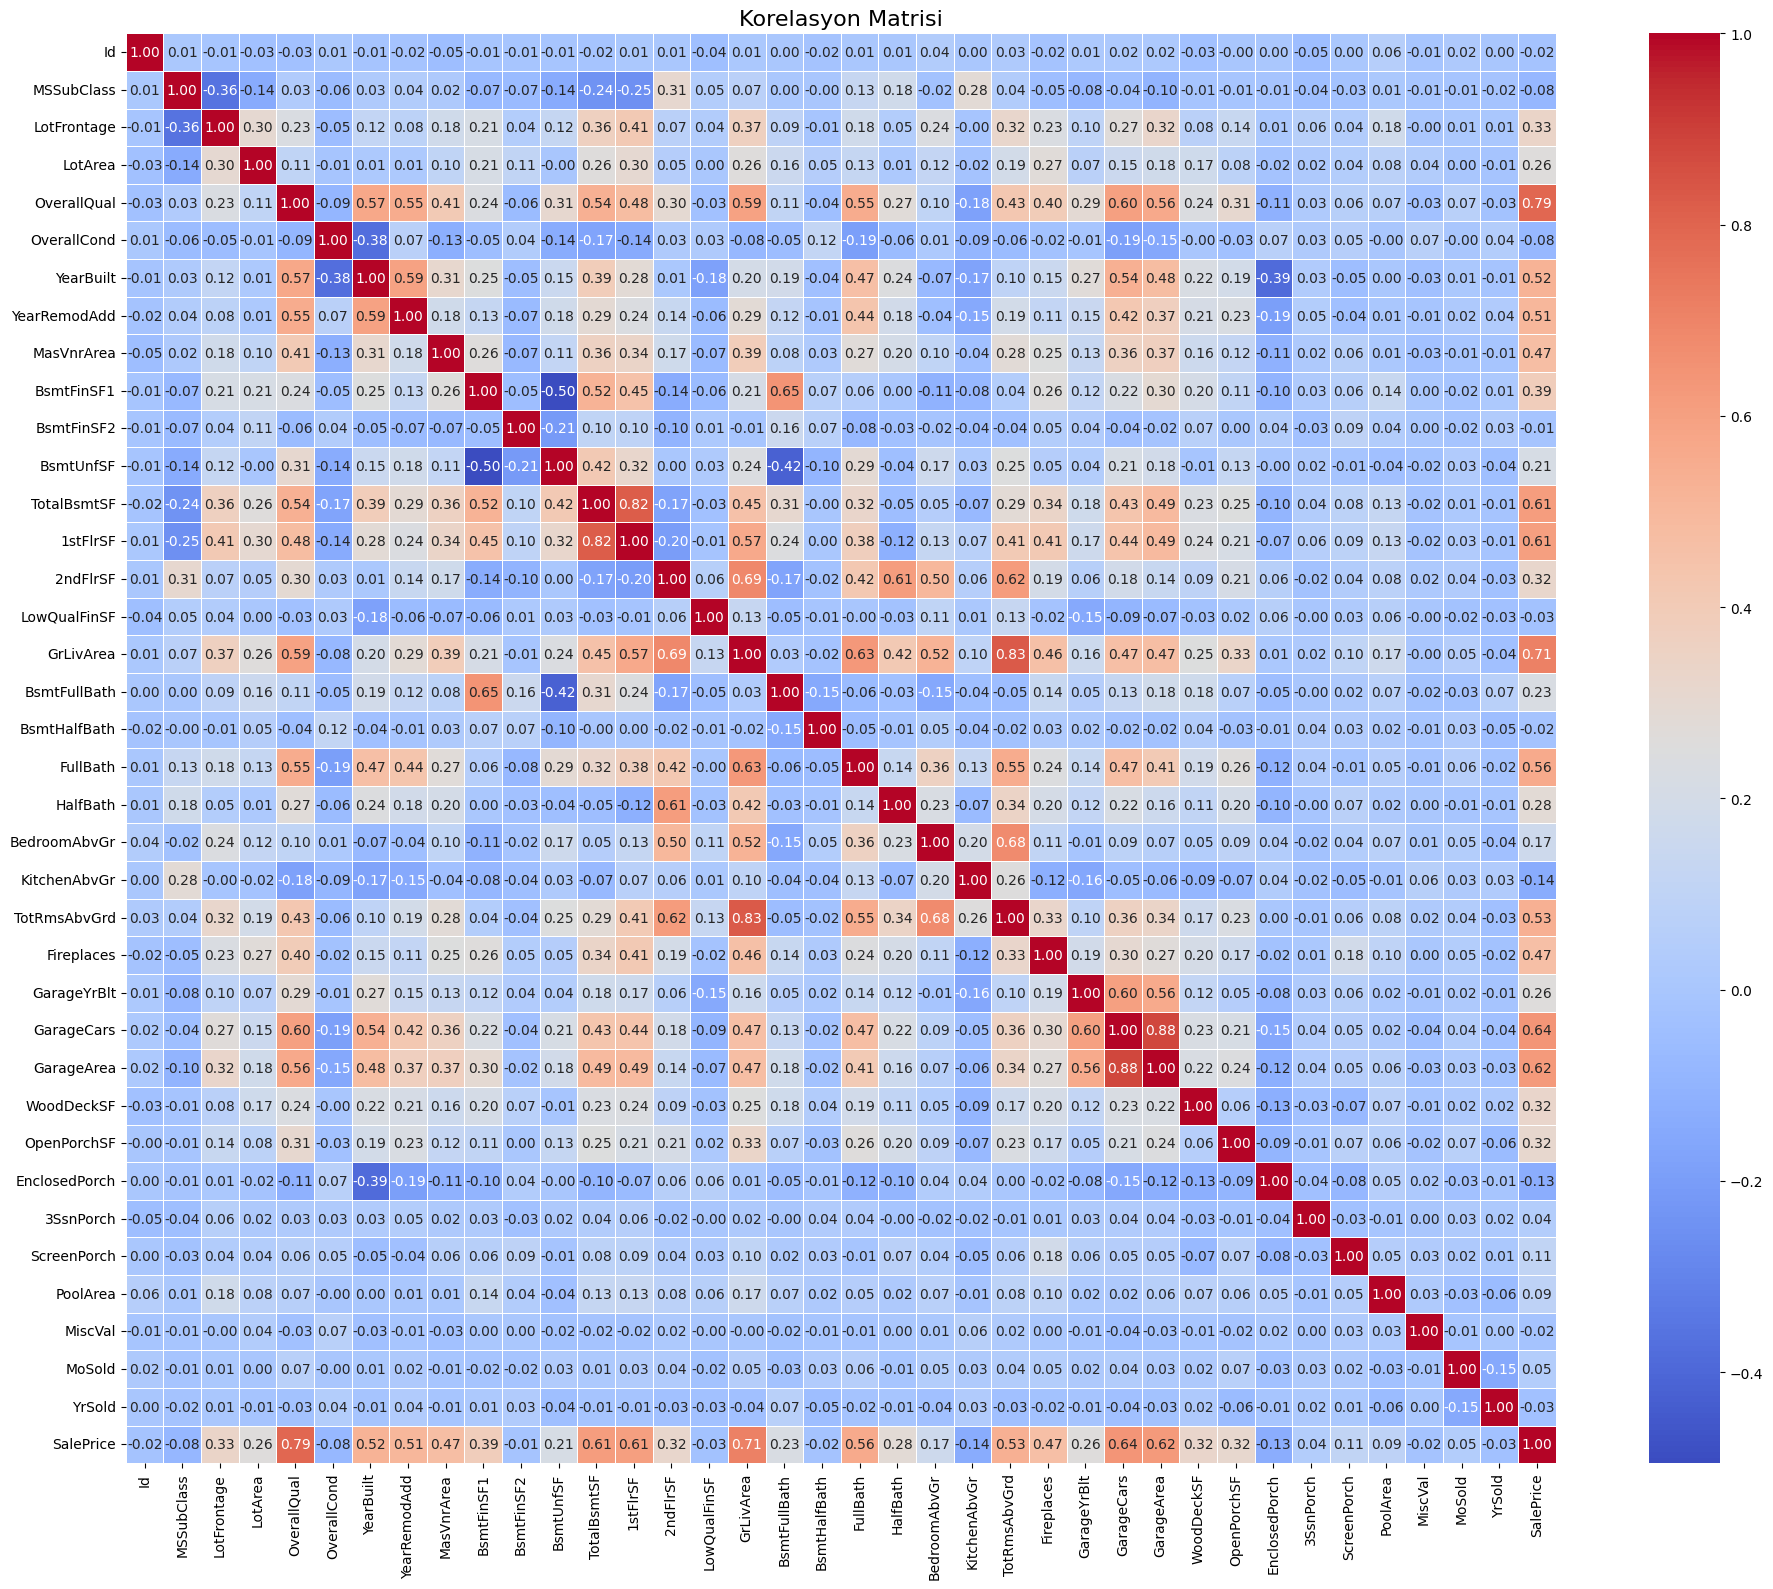

In [ ]:
# Korelasyon matrisi
numeric_df = df.select_dtypes(include=['int64', 'float64'])
corr_matrix = numeric_df.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Korelasyon Matrisi", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
# features
selected_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'MasVnrArea']
X_selected = df[selected_features]
y = df['SalePrice']

#ölçeklendirme
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

#train set
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [ ]:
#linear
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

#modeli değerlendir
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


Mean Squared Error: 1477339833.6518853
R^2 Score: 0.8073954361592064


In [ ]:
#ridge ve lasso için gridsearch
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
lasso_params = {'alpha': [0.01, 0.1, 1, 10, 100]}

ridge = Ridge()
ridge_grid_search = GridSearchCV(ridge, ridge_params, cv=5)
ridge_grid_search.fit(X_train, y_train)

lasso = Lasso()
lasso_grid_search = GridSearchCV(lasso, lasso_params, cv=5)
lasso_grid_search.fit(X_train, y_train)

#en iyi parametreler
print(f"Ridge Best Alpha: {ridge_grid_search.best_params_}")
print(f"Ridge Best Score: {ridge_grid_search.best_score_}")
print(f"Lasso Best Alpha: {lasso_grid_search.best_params_}")
print(f"Lasso Best Score: {lasso_grid_search.best_score_}")


Ridge Best Alpha: {'alpha': 100}
Ridge Best Score: 0.7589026215428962
Lasso Best Alpha: {'alpha': 100}
Lasso Best Score: 0.755860374554811


In [ ]:
#eğit
ridge_best = Ridge(alpha=ridge_grid_search.best_params_['alpha'])
lasso_best = Lasso(alpha=lasso_grid_search.best_params_['alpha'])
ridge_best.fit(X_train, y_train)
lasso_best.fit(X_train, y_train)

#tahminler ve değerlendirme
ridge_pred = ridge_best.predict(X_val)
lasso_pred = lasso_best.predict(X_val)
ridge_mse = mean_squared_error(y_val, ridge_pred)
ridge_r2 = r2_score(y_val, ridge_pred)
lasso_mse = mean_squared_error(y_val, lasso_pred)
lasso_r2 = r2_score(y_val, lasso_pred)

print(f"Ridge - Mean Squared Error: {ridge_mse}, R²: {ridge_r2}")
print(f"Lasso - Mean Squared Error: {lasso_mse}, R²: {lasso_r2}")


Ridge - Mean Squared Error: 1500184309.210153, R²: 0.8044171435884337
Lasso - Mean Squared Error: 1479267731.3469331, R²: 0.807144091217287


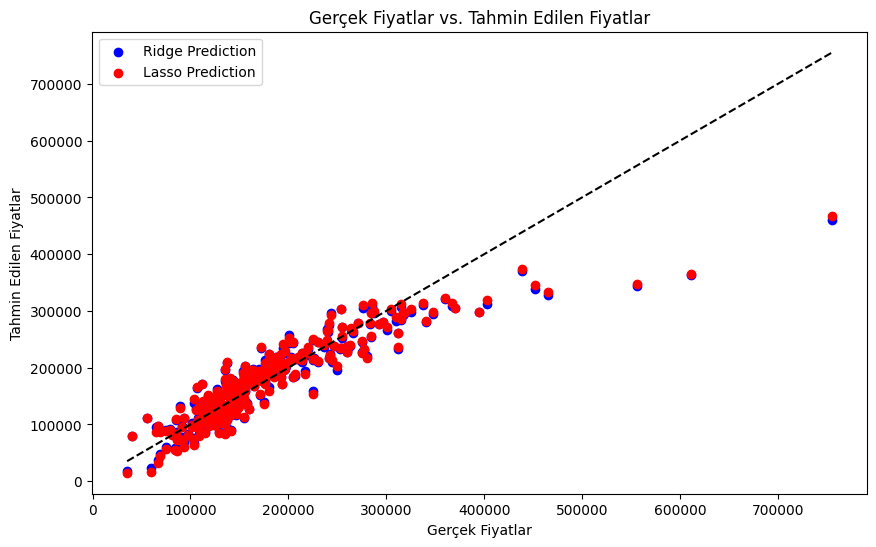

In [ ]:
#tahminler(lasso- ridge) görselleştirme
plt.figure(figsize=(10, 6))
plt.scatter(y_val, ridge_pred, color='blue', label='Ridge Prediction')
plt.scatter(y_val, lasso_pred, color='red', label='Lasso Prediction')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='black', linestyle='--')
plt.xlabel('Gerçek Fiyatlar')
plt.ylabel('Tahmin Edilen Fiyatlar')
plt.title('Gerçek Fiyatlar vs. Tahmin Edilen Fiyatlar')
plt.legend()
plt.show()

#lasso az farkla daha iyi


In [ ]:
#Test datası
test_data = pd.read_csv('/content/drive/MyDrive/test_house.csv')

#temizle
categorical_cols = test_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    test_data[col] = test_data[col].fillna(test_data[col].mode()[0])

numerical_cols = test_data.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    test_data[col] = test_data[col].fillna(test_data[col].mean())

#scale
X_test = test_data[selected_features]
X_test_scaled = scaler.transform(X_test)

#lasso ile tahmin
test_predictions = lasso_best.predict(X_test_scaled)

In [ ]:
#sonuçları df'e kaydet
submission = pd.DataFrame({'Id': test_data['Id'], 'SalePrice': test_predictions})

#.csv
submission.to_csv('/content/drive/MyDrive/lasso_predictions.csv', index=False)

print(submission.head())

     Id      SalePrice
0  1461  100004.145823
1  1462  149097.258648
2  1463  174589.117869
3  1464  192188.269919
4  1465  209318.829805


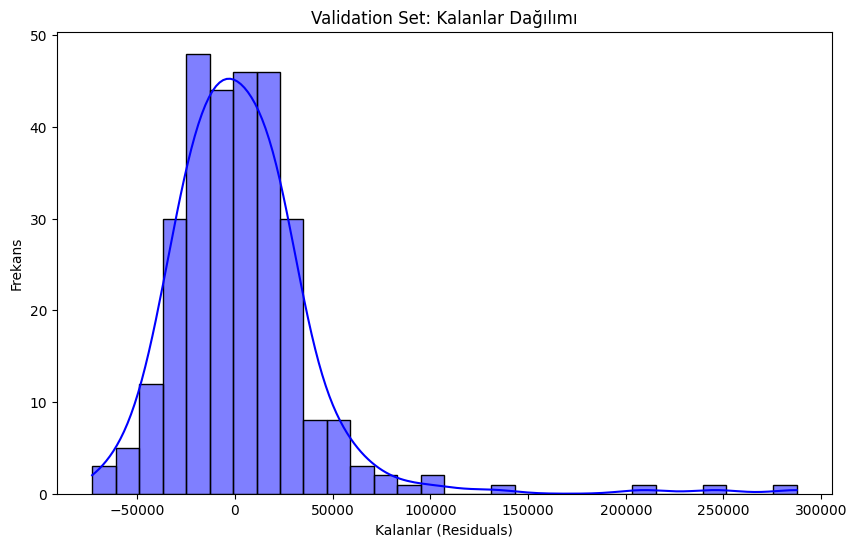

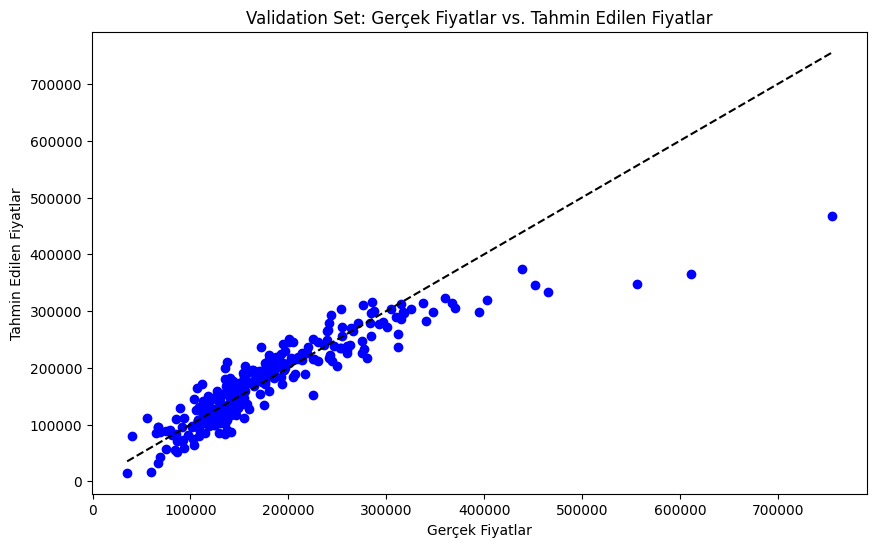

In [ ]:
#validation set üzerindeki residuals
val_residuals = y_val - y_pred

#Hata dağılımı
plt.figure(figsize=(10, 6))
sns.histplot(val_residuals, kde=True, color='blue', bins=30)
plt.xlabel('Kalanlar (Residuals)')
plt.ylabel('Frekans')
plt.title('Validation Set: Kalanlar Dağılımı')
plt.show()

#Gerçek - Tahmin edilen Fiyat
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, color='blue')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='black', linestyle='--')
plt.xlabel('Gerçek Fiyatlar')
plt.ylabel('Tahmin Edilen Fiyatlar')
plt.title('Validation Set: Gerçek Fiyatlar vs. Tahmin Edilen Fiyatlar')
plt.show()
